In [3]:
import pandas as pd
import os
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'preprocessed_data.csv'))

x = df.drop(['shares', 'log_shares', 'popular', 'weekday', 'channel'], axis=1)
y = df['log_shares']

In [6]:
x.shape, y.shape

((39644, 60), (39644,))

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6)

standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)
x_train.shape, x_test.shape

((31715, 60), (7929, 60))

In [36]:
# baseline model
from sklearn.dummy import DummyRegressor
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(x_train, y_train)

DummyRegressor()

In [37]:
import lightgbm as lgb

# best tuned model
def create_lgb_model():
    return lgb.LGBMRegressor(
        **{'n_estimators': 192, 
         'max_depth': 81,
      'learning_rate': 0.031661039134099456, 
      'num_leaves': 74, 'lambda_l1': 0.12512871448721335,
        'lambda_l2': 0.0035628067238089207, 'min_child_samples': 61},
        verbose=-1
        )

lgb_model = create_lgb_model()

In [38]:
lgb_model.fit(x_train, y_train)

LGBMRegressor(lambda_l1=0.12512871448721335, lambda_l2=0.0035628067238089207,
              learning_rate=0.031661039134099456, max_depth=81,
              min_child_samples=61, n_estimators=192, num_leaves=74,
              verbose=-1)

In [39]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

def evaluate_model(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    pearson_corr, _ = pearsonr(y_test, y_pred)
    return mse, mae, r2, pearson_corr

In [40]:
y_pred_lgb = lgb_model.predict(x_test)
y_pred_dummy = dummy_model.predict(x_test)

metrics_lgb = evaluate_model(y_pred_lgb, y_test)
metrics_dummy = evaluate_model(y_pred_dummy, y_test)

metrics_lgb, metrics_dummy

/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/tmp/ipykernel_40553/3029113897.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_test, y_pred)


((0.7137110196566823,
  0.6205463805808934,
  0.18979267724825077,
  np.float64(0.43638360653838953)),
 (0.8810002430737978,
  0.7078567985989853,
  -0.00011465232499729971,
  np.float64(nan)))

## Dimensionality reduction

### PCA

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Also create an overlapping histogram for direct comparison



In [64]:
from sklearn.decomposition import PCA
import numpy as np


# train model with PCA with different number of components
explained_variances = np.arange(0.5, 1.0, 0.1)
explained_variances = np.append(explained_variances, 0.95)
explained_variances = np.append(explained_variances, 0.99)
explained_variances = np.append(explained_variances, 0.2)
stats = []
for ev in explained_variances:
    test_stat = {}
    test_stat['explained_variance'] = ev.item()
    pca = PCA(n_components=ev)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    test_stat['num_components'] = x_train_pca.shape[1]
    lgb_model = create_lgb_model()
    lgb_model.fit(x_train_pca, y_train)
    y_pred_pca = lgb_model.predict(x_test_pca)
    metrics_pca = evaluate_model(y_pred_pca, y_test)
    test_stat['metrics'] = metrics_pca
    test_stat['y_pred'] = y_pred_pca
    stats.append(test_stat)

# train model with normal features
lgbm_model = create_lgb_model()
lgbm_model.fit(x_train, y_train)
y_pred_lgbm = lgbm_model.predict(x_test)
metrics_lgbm = evaluate_model(y_pred_lgbm, y_test)
stats.append({'explained_variance': None, 'num_components': x_train.shape[1], 'metrics': metrics_lgbm, 'y_pred': y_pred_lgbm})

/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

In [65]:
len(stats)

9

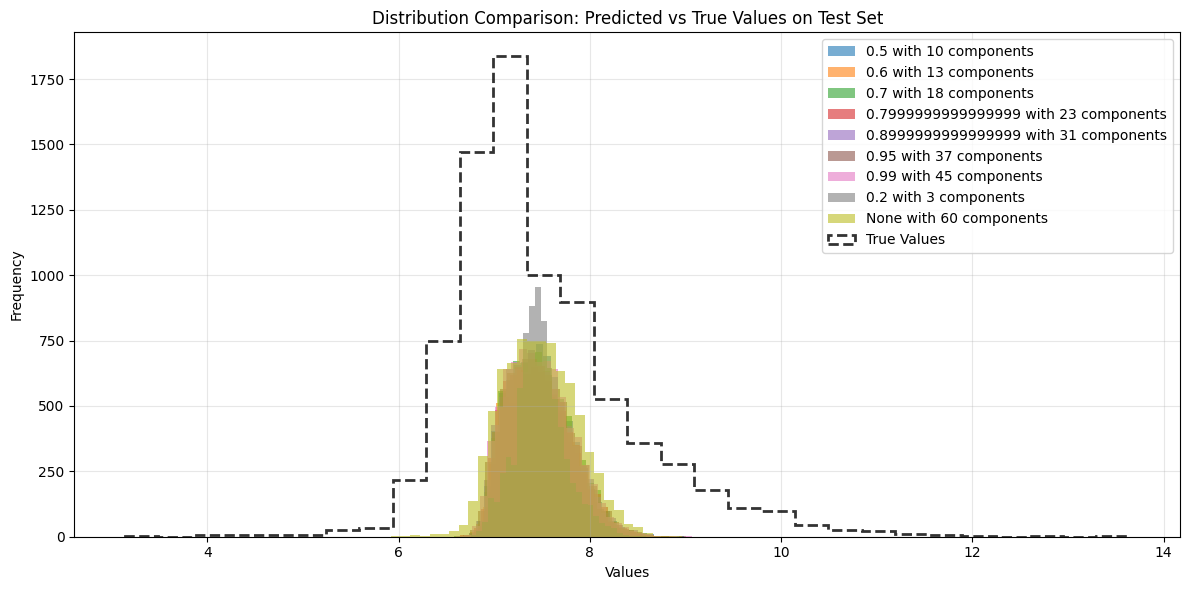

In [66]:
plt.figure(figsize=(12, 6))
for stat in stats:
    plt.hist(stat['y_pred'], bins=30, alpha=0.6, label=f'{stat['explained_variance']} with {stat['num_components']} components')
plt.hist(y_test, bins=30, alpha=0.8, label='True Values', color='black', linestyle='--', histtype='step', linewidth=2)

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution Comparison: Predicted vs True Values on Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

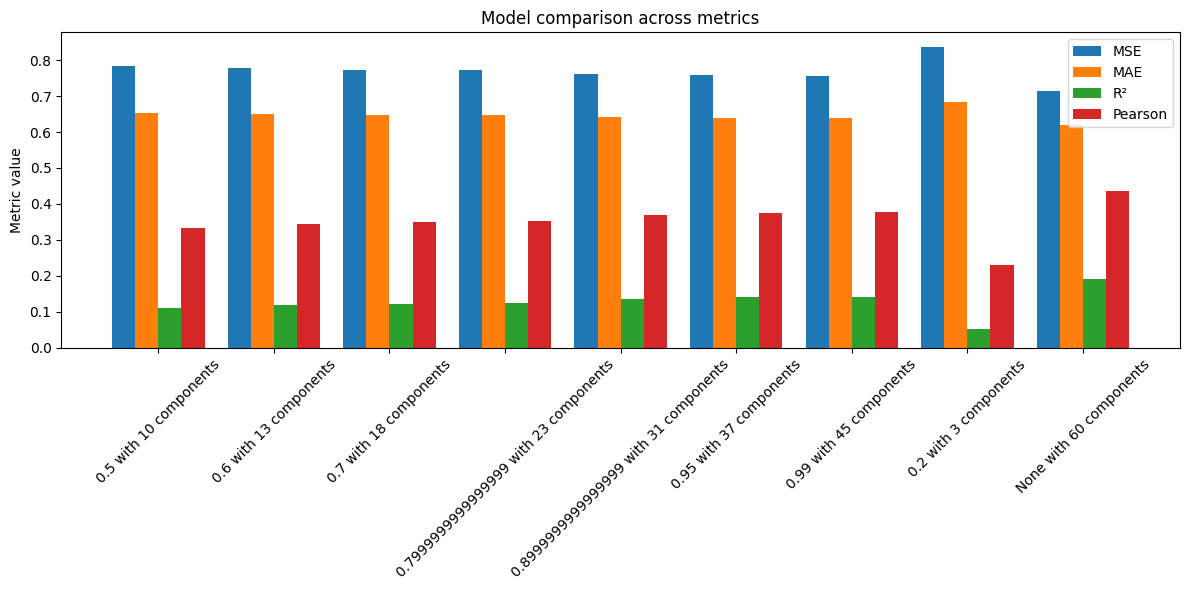

In [74]:
result = [s['metrics'] for s in stats]
results = np.array(result)  # shape: (10 models, 4 metrics)
model_names = [str(s['explained_variance']) + ' with ' + str(s['num_components']) + ' components' for s in stats]
metric_names = [ 'MSE', 'MAE',  'R²', 'Pearson']

# Transpose so metrics are on rows for plotting
results_T = results.T

x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.bar(x + i*width, results_T[i], width=width, label=metric_names[i])

plt.xticks(x + 1.5 * width, model_names, rotation=45)
plt.ylabel('Metric value')
plt.title('Model comparison across metrics')
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
from umap import UMAP
import numpy as np

# Create a UMAP model
umap_model = UMAP(n_components=10, random_state=6)

x_train_umap = umap_model.fit_transform(x_train)
x_test_umap = umap_model.transform(x_test)

lgb_model = create_lgb_model()
lgb_model.fit(x_train_umap, y_train)
y_pred_umap = lgb_model.predict(x_test_umap)
metrics_umap = evaluate_model(y_pred_umap, y_test)

/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/si

In [76]:
metrics_umap

(0.8124756053308844,
 0.6634475322354508,
 0.0776747635017695,
 np.float64(0.28079850767637166))

In [77]:
stats[0]['metrics']

(0.7834515325675201,
 0.6535210240910746,
 0.11062299554709942,
 np.float64(0.3330189643469669))